In [1]:
#We have used both regression as well as classification


import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import load_img

In [3]:
#from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

In [4]:
BASE_DIR = 'UTKFace'    #Load dataset

In [5]:
BASE_DIR

'UTKFace'

In [6]:
#Load all images along with labels

# labels - age, gender, ethnicity

image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/137 [00:00<?, ?it/s]

In [7]:
# convert to dataframe
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head()

image  age  gender
0  UTKFace\100_0_0_20170112213500903.jpg.chip.jpg  100       0
1  UTKFace\100_0_0_20170112215240346.jpg.chip.jpg  100       0
2  UTKFace\100_1_0_20170110183726390.jpg.chip.jpg  100       1
3  UTKFace\100_1_0_20170112213001988.jpg.chip.jpg  100       1
4  UTKFace\100_1_0_20170112213303693.jpg.chip.jpg  100       1

In [8]:
# map labels for gender
gender_dict = {0:'Male', 1:'Female'}

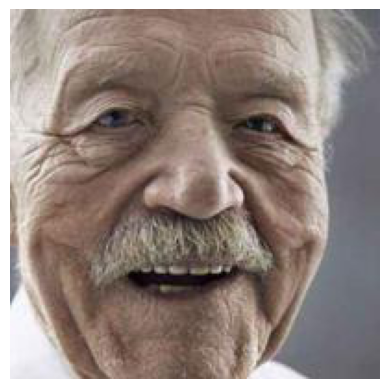

In [9]:
#Exploratory Data Analysis
from PIL import Image     #PIL (Python Imaging Library) module is a library in Python used for opening, manipulating, and saving various image file formats. It is a powerful library that allows users to perform various operations on images, such as resizing, cropping, flipping, rotating, filtering, and more.
img = Image.open(df['image'][0])    #show first image
plt.axis('off')      # removes the axis lines and labels from the current plot
plt.imshow(img);

<AxesSubplot:xlabel='age', ylabel='Density'>

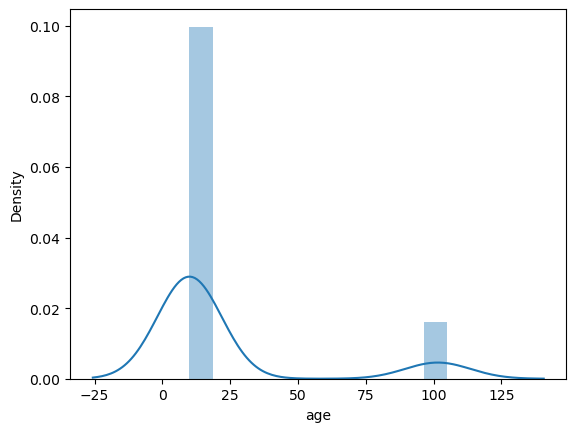

In [10]:
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

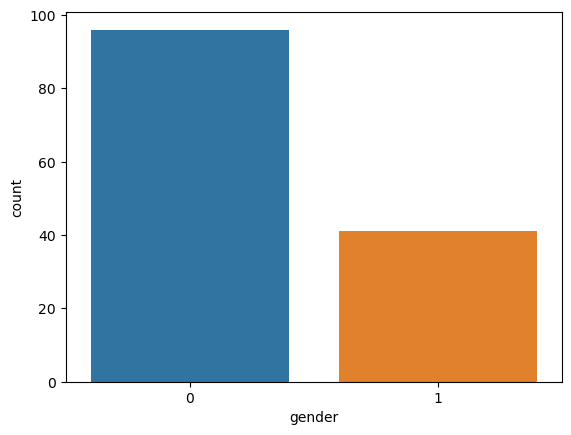

In [11]:
sns.countplot(df['gender'])

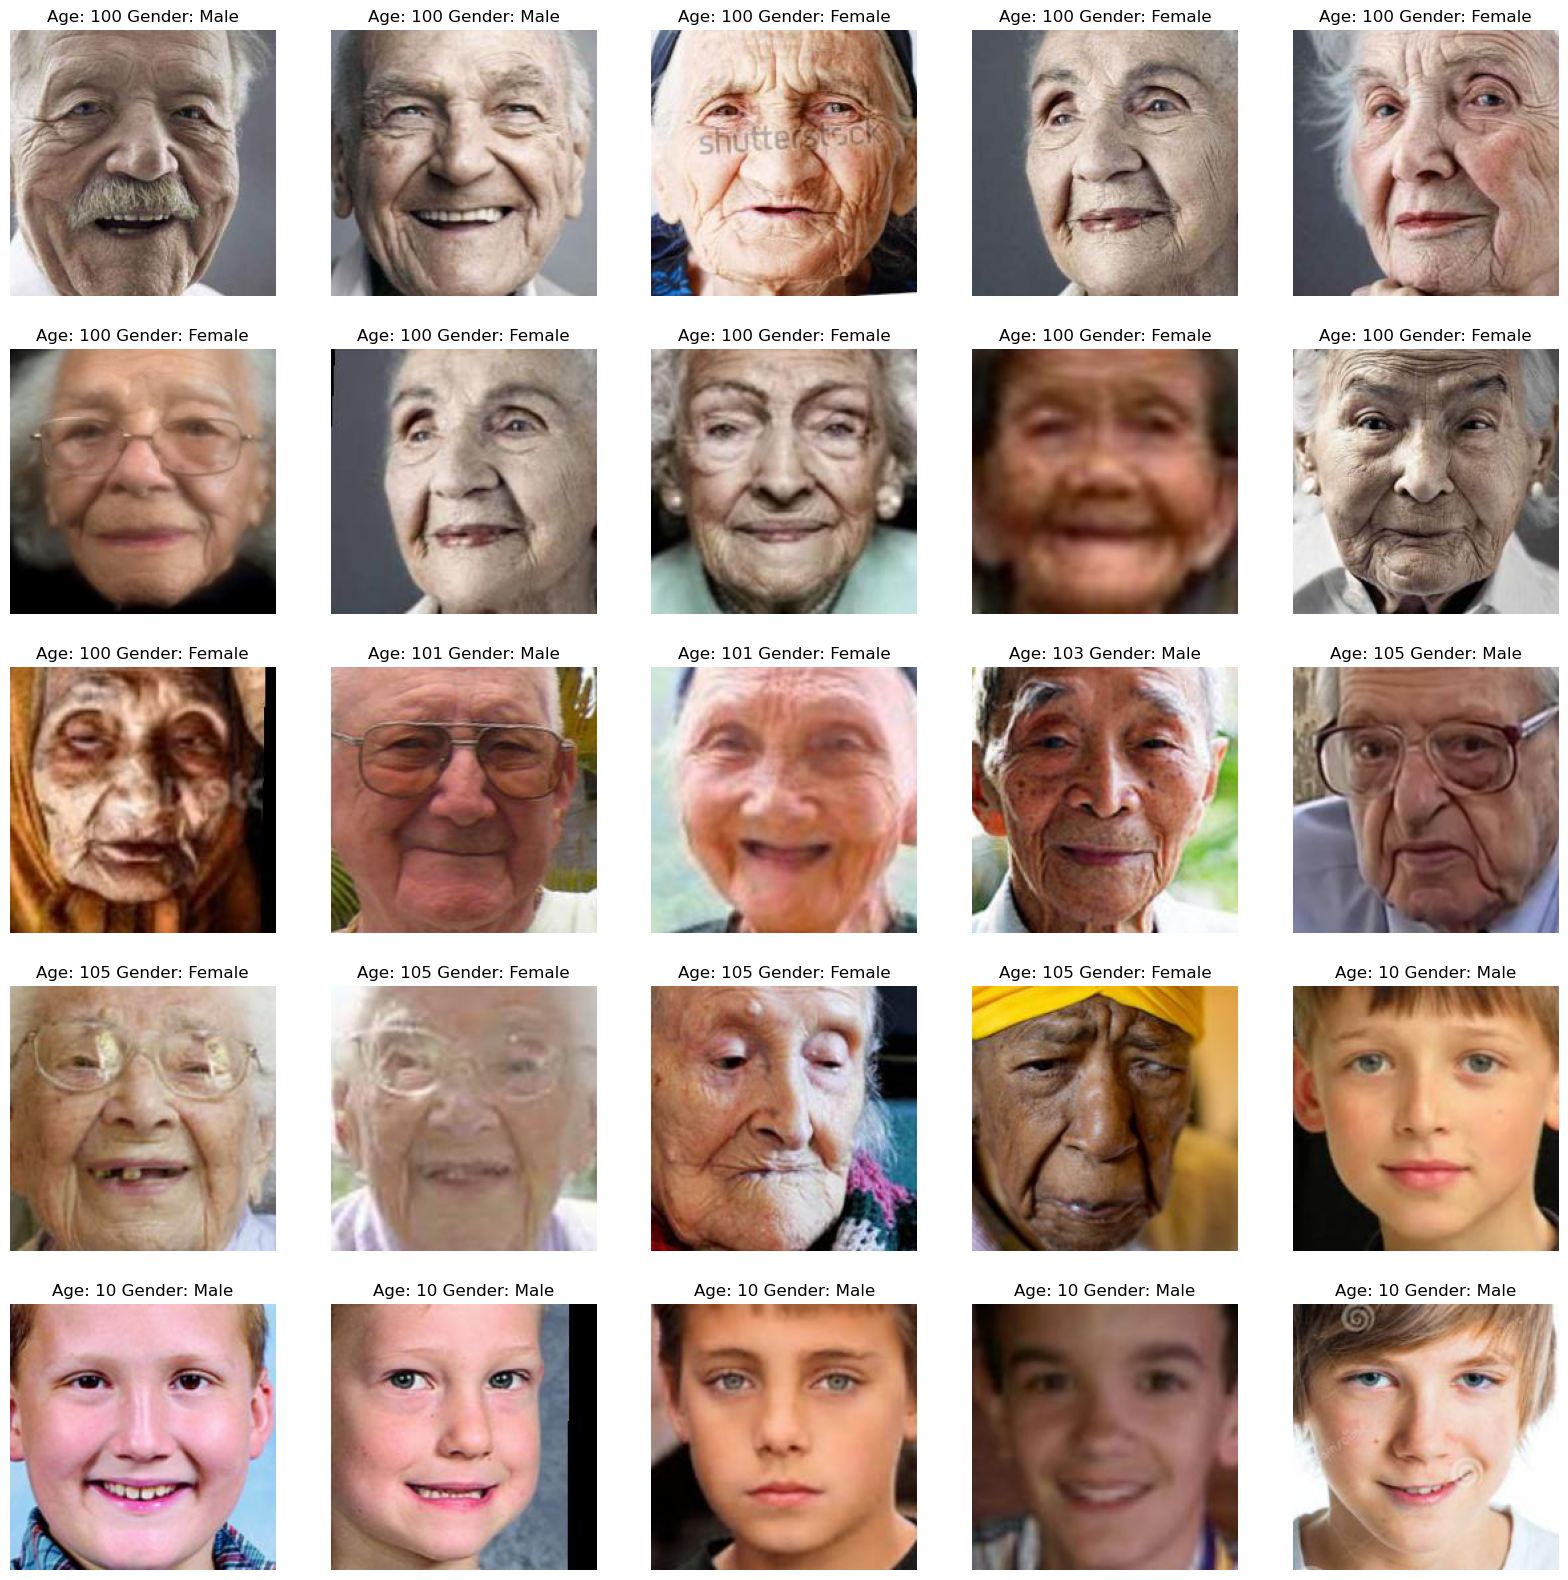

In [12]:
# to display grid of images
plt.figure(figsize=(20, 20))
files = df.iloc[0:25]    #first 25 images

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)         #index start from 1
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')


In [13]:
#Feature extraction
def extract_features(images):
    features = []    #list
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [14]:
X = extract_features(df['image'])

  0%|          | 0/137 [00:00<?, ?it/s]

In [15]:
X.shape

(137, 128, 128, 1)

In [16]:
# normalize the images
X = X/255.0

In [17]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [18]:
input_shape = (128, 128, 1) 

In [19]:
#Model Creation
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu') (inputs) #convolutional layer1
maxp_1 = MaxPooling2D(pool_size=(2, 2)) (conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu') (maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2, 2)) (conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu') (maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2, 2)) (conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu') (maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2, 2)) (conv_4)

flatten = Flatten() (maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu') (flatten)
dense_2 = Dense(256, activation='relu') (flatten)

dropout_1 = Dropout(0.3) (dense_1)
dropout_2 = Dropout(0.3) (dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2 = Dense(1, activation='relu', name='age_out') (dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=['accuracy'])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

In [34]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [21]:
# train model
history = model.fit(x=X, y=[y_gender, y_age],batch_size=32, epochs=30, validation_split=0.2) 

Epoch 1/30
4/4 [==============================] - 18s 2s/step - loss: 22.6250 - gender_out_loss: 0.6968 - age_out_loss: 21.9282 - gender_out_accuracy: 0.7248 - age_out_accuracy: 0.0000e+00 - val_loss: 5.6752 - val_gender_out_loss: 3.6946 - val_age_out_loss: 1.9807 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00
Epoch 2/30
4/4 [==============================] - 18s 5s/step - loss: 18.2578 - gender_out_loss: 0.4672 - age_out_loss: 17.7905 - gender_out_accuracy: 0.8716 - age_out_accuracy: 0.0000e+00 - val_loss: 2.8677 - val_gender_out_loss: 1.5401 - val_age_out_loss: 1.3277 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00
Epoch 3/30
4/4 [==============================] - 7s 2s/step - loss: 17.8430 - gender_out_loss: 0.3820 - age_out_loss: 17.4610 - gender_out_accuracy: 0.8716 - age_out_accuracy: 0.0000e+00 - val_loss: 5.8397 - val_gender_out_loss: 3.6670 - val_age_out_loss: 2.1728 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00

4/4 [==============================] - 7s 2s/step - loss: 17.0793 - gender_out_loss: 0.3922 - age_out_loss: 16.6871 - gender_out_accuracy: 0.8716 - age_out_accuracy: 0.0000e+00 - val_loss: 2.5976 - val_gender_out_loss: 1.9240 - val_age_out_loss: 0.6736 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00
Epoch 26/30
4/4 [==============================] - 8s 2s/step - loss: 17.2403 - gender_out_loss: 0.4026 - age_out_loss: 16.8378 - gender_out_accuracy: 0.8716 - age_out_accuracy: 0.0000e+00 - val_loss: 2.3524 - val_gender_out_loss: 1.9505 - val_age_out_loss: 0.4019 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00
Epoch 27/30
4/4 [==============================] - 7s 2s/step - loss: 17.2413 - gender_out_loss: 0.3878 - age_out_loss: 16.8535 - gender_out_accuracy: 0.8716 - age_out_accuracy: 0.0000e+00 - val_loss: 3.5079 - val_gender_out_loss: 2.0855 - val_age_out_loss: 1.4224 - val_gender_out_accuracy: 0.0357 - val_age_out_accuracy: 0.0000e+00
Epoch 28/3

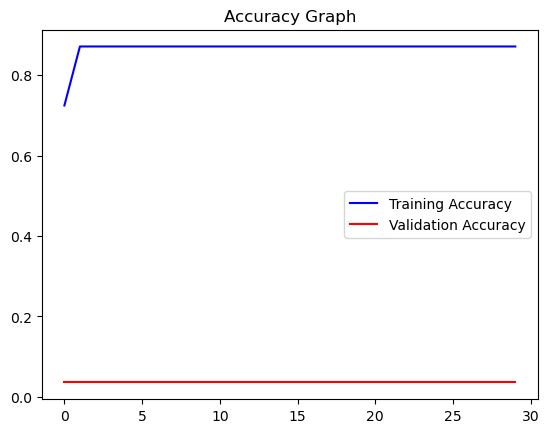

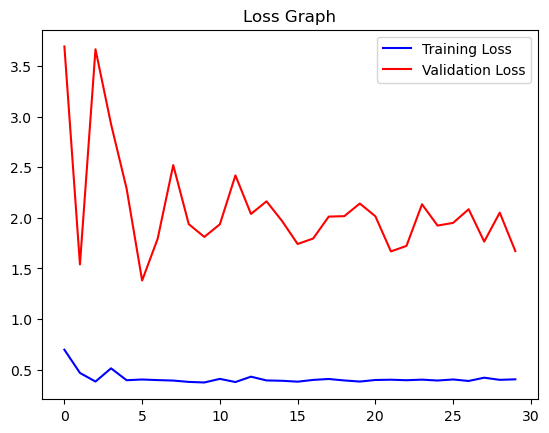

In [22]:
#Plot the results
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

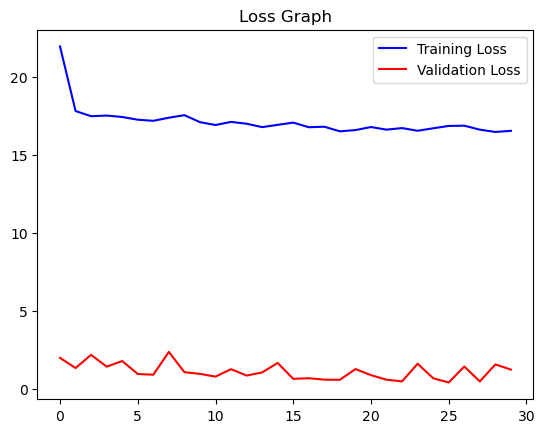

In [23]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Gender: Male Original Age: 10
1/1 [==============================] - 1s 825ms/step
Predicted Gender: Male Predicted Age: 10


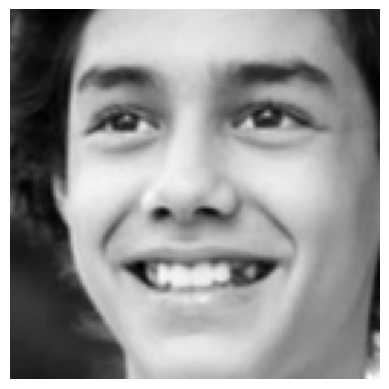

In [24]:
#Prediction with test
image_index = 100
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 128ms/step
Predicted Gender: Male Predicted Age: 8


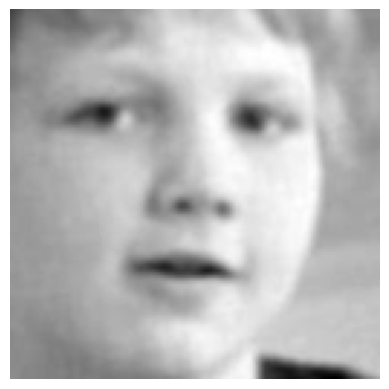

In [25]:
image_index = 50
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 248ms/step
Predicted Gender: Male Predicted Age: 9


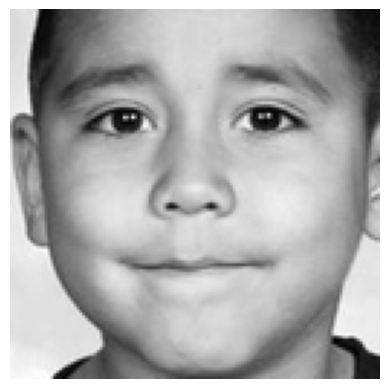

In [26]:
image_index = 102
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 10
1/1 [==============================] - 0s 200ms/step
Predicted Gender: Male Predicted Age: 9


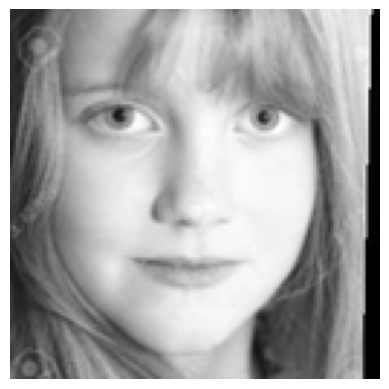

In [27]:
image_index = 115
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 10
1/1 [==============================] - 0s 224ms/step
Predicted Gender: Male Predicted Age: 9


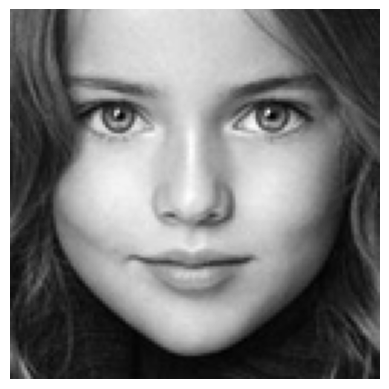

In [28]:
image_index = 120
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 10
1/1 [==============================] - 0s 160ms/step
Predicted Gender: Male Predicted Age: 9


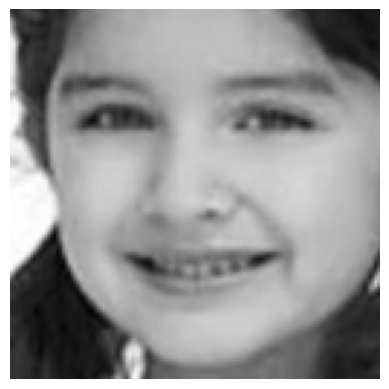

In [29]:
image_index = 130
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Female Original Age: 10
1/1 [==============================] - 0s 112ms/step
Predicted Gender: Male Predicted Age: 9


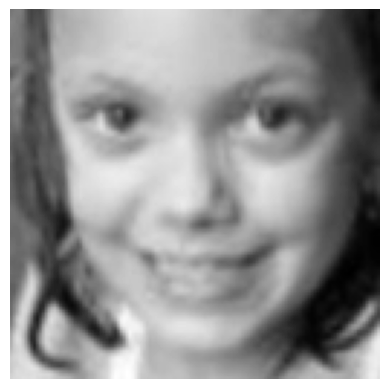

In [30]:
image_index = 117
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 10
1/1 [==============================] - 0s 88ms/step
Predicted Gender: Male Predicted Age: 8


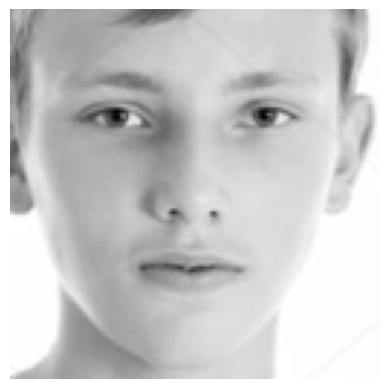

In [31]:
image_index = 25
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');

Original Gender: Male Original Age: 100
1/1 [==============================] - 0s 88ms/step
Predicted Gender: Male Predicted Age: 10


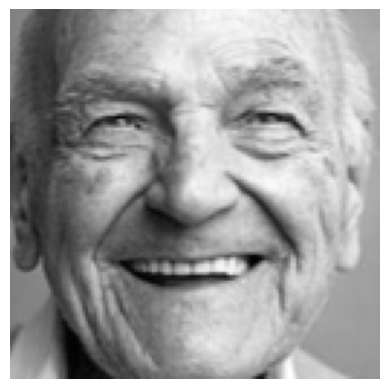

In [32]:
image_index = 1
print("Original Gender:", gender_dict[y_gender[image_index]], "Original Age:", y_age[image_index])
# predict from model
pred = model.predict(X[image_index].reshape(1, 128, 128, 1))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
print("Predicted Gender:", pred_gender, "Predicted Age:", pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128, 128), cmap='gray');